In [1]:
import joblib
import pandas as pd
import numpy as np
import scipy.stats as stats
import random
import tensorflow as tf

import matplotlib.pyplot as plt
import keras
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
import csv
from keras import layers
gpus= tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
random.seed(1)

In [3]:

class RawData():
    def __init__(self, fname):
        self.df = pd.read_csv(fname)

    def get_df(self):
        return self.df

    def get_seqs(self):
        return self.df['utr'].tolist()

    def get_labels(self):
        return self.df['rl'].tolist()

def onehot_coder(seq):   ## single seq (str)
    inp_len = 50
    nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1]}

    onehotmtx = np.empty([1, inp_len, 4])  ## initial, shape = N,50,4
    seq = seq.lower()
    for n, x in enumerate(seq):
        onehotmtx[0][n] = np.array(nuc_d[x])
    return onehotmtx

def binary_mtx(mtxs, seqlen=50):  
    b_mtx = np.zeros([len(mtxs), seqlen, 4])
    for i in range(len(mtxs)):   
        for k in range(seqlen):  
            base = mtxs[i][k].tolist()  
            b_mtx[i][k][base.index(max(base))] = 1 
    return b_mtx

def decode_seq(mtx, seqlen=50):  ## 传入单个mtx
    nuc_d = {'a': [1, 0, 0, 0], 'c': [0, 1, 0, 0], 'g': [0, 0, 1, 0], 't': [0, 0, 0, 1] }
    seq=[]
    for i in range(seqlen):
        for x in ['a', 'c', 'g', 't']:
            if((mtx[i]==nuc_d[x]).all()):  ## list 相等
                seq.append(x)
                break

    return "".join(seq)

In [4]:

def r2(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value ** 2


In [5]:

def distort(decoder, oldseq, old_bottleneck, necklen, coef=1.2):
    times = 0
    newseq = ''
    # while ((newseq == '') or (newseq == oldseq) :
    while ((newseq == '') or (newseq == oldseq) or ('atg' in newseq )):  ## no uAUG
        times += 1
        new_bottleneck = old_bottleneck * (np.append((coef + np.random.normal(0, 1, (1, necklen)) / 4), [coef] * 20))
        decodedmtx = decoder.predict(new_bottleneck)  ## shape(1,50,4) ，numeric
        newseq = decode_seq(binary_mtx(decodedmtx)[0])  ## single seq -> binary mtx -> str
        if (times > 1000):
            return oldseq
    return newseq


In [6]:

def newseqs_distribution(df, autoencoder, scaler, encoder, decoder, rawseq, rawrl, iter_times=10, coef=1.2, necklen = 80): # iteration from single old seq

    old_bottleneck = encoder.predict(onehot_coder(rawseq))
    newseq_rl = []
    for i in range(iter_times):
        newseq = distort(decoder, rawseq, old_bottleneck, necklen, coef)
        newrl = autoencoder.predict(onehot_coder(newseq))[1]
        newrl = scaler.inverse_transform(newrl).reshape(-1)[0]
        newseq_rl.append(newrl)

    df[coef] = newseq_rl
    return 0


def vectorizeSequence(seq):
    # the order of the letters is not arbitrary.
    # Flip the matrix up-down and left-right for reverse compliment
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    return np.array([ltrdict[x] for x in seq])

## Genetic algorithm
def ret_rand_nuc():
    x = random.randint(0, 3)
    if x == 0:
        return [1, 0, 0, 0]  # A
    if x == 1:
        return [0, 1, 0, 0]  # C
    if x == 2:
        return [0, 0, 1, 0]  # G
    if x == 3:
        return [0, 0, 0, 1]  # T

def simple_mutate(seq, nbr_bases=1, prob=1):
    if nbr_bases > 1 and prob > random.random():
        nbr_bases = nbr_bases
    else:
        nbr_bases = 1
    for i in range(nbr_bases):
        pos = random.randint(0, 49)
        seq[pos] = ret_rand_nuc()
    return seq


def newseqs_distribution_ga(df,rawseq, iter_times=10):
    evolved_seqs = {}
    nbr_bases_to_mutate = 2
    prob_of_multi_mutation = 0.5

    scaler = joblib.load("../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_200k.scaler")
    model = keras.models.load_model('../models/Optimus5-Prime/Optimus5_egfp_m1pseudo2_model_200k_0.8.h5')
    rawseq=rawseq
    newseq_rl = []

    e_seq = vectorizeSequence(rawseq.lower()) 
    for i in range(iter_times):
        newseq = simple_mutate(e_seq.copy(), nbr_bases=nbr_bases_to_mutate, prob=prob_of_multi_mutation)
        newrl = model.predict(newseq[np.newaxis,:,:])[0]  ## [0.8927041]
        newrl  = scaler.inverse_transform(newrl)[0]
        newseq_rl.append(newrl)
    df['ga'] = newseq_rl


def get_mother_seq(fname, init_rl, random_state=1):
    df = pd.read_csv(fname)
    df.sort_values('total', inplace=True, ascending=False)
    df.reset_index(inplace=True, drop=True)
    df = df.iloc[:20000]  ## test dataset
    df = df.loc[(df['rl']< init_rl + 0.1) & (df['rl']>init_rl - 0.1)]
    df = df.loc[~df['utr'].str.contains('TAG|TGA|TAA|ATG')]
    df = df.sample(frac=1,random_state=random_state).reset_index(drop=True) ## .iloc[:nbr_sequences]  ## random select
    motherseqs = df['utr'].to_list()
    motherlabels = df['rl'].to_list()

    return motherseqs[0], motherlabels[0]


In [9]:

def main():

    seqlen = 50
    necklen = 80
    ### load model
    modelpath = '../models/Auto-m1p/egfp_m1pseudo2_neck100_autoencoder_200k.h5'
    scalerpath = '../models/Auto-m1p/egfp_m1pseudo2_neck100_autoencoder_200k.scaler'

    model = keras.models.load_model(modelpath)
    scaler = joblib.load(scalerpath)

    # autoencoder.summary()
    for layer in model.layers[:]:  ## frozen
        layer.trainable = False

    ## get decoder
    decoder_input = keras.Input(shape=(necklen + 20))
    for i, layer in enumerate(model.layers):
        if (layer.name=='decoded_input'):
            deco1layer_index = i   ## input: from concatenat
        elif (layer.name=='decoded_drop1'):
            nectlayer_index = i

    de = model.layers[deco1layer_index](decoder_input)
    for layer in model.layers[nectlayer_index:]:
        de = layer(de)

    encoder = keras.Model(inputs=model.input, outputs= model.get_layer('concatenate').output)
    decoder = keras.Model(inputs=decoder_input, outputs=de)

    ## collect prototype seqs from test dataset
    prototype_seq, prototype_label = get_mother_seq('../../egfp_5UTRpseudo/data/GSM3130440_egfp_m1pseudo_2.csv', init_rl=6.5,random_state=888)


    ## plot distribution of new generated seqs

    newseq_nums = 500  ## how many novel seq in each iteration
    dfmrl = pd.DataFrame()  ## record MRL value of new seqs
    for c in np.arange(0.5, 2.5, 0.25):

        newseqs_distribution(dfmrl, model, scaler, encoder, decoder, prototype_seq, prototype_label, iter_times=newseq_nums, coef=c, necklen=80)

    newseqs_distribution_ga(df=dfmrl, rawseq=prototype_seq, iter_times=newseq_nums)

    print(dfmrl)

    print("prototype's seq = ", prototype_seq)
    print("prototype's MRL = ",prototype_label)
    print("random times in a single figure = ", newseq_nums)


    binwidth = 0.05
    col_nums = 3  # how many plots per row
    row_nums = int(dfmrl.shape[1] / col_nums)
    fig, axs = plt.subplots(row_nums, col_nums,figsize=(6, 8), dpi=200) ## figsize=(6, 8)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    axs = axs.ravel()  ## to 1-d array

    # colors = cm.Set3(np.linspace(0, 1, 2))

    fig_num = dfmrl.shape[1]
    for i, (k, v) in enumerate(dfmrl.items(), 1):
        ax = axs[i-1]  ## i start from 1
        # v.plot.hist(density=True, bins=30, ax=ax, color=colors)
        if i == fig_num:
            v.plot.hist(density=True, bins=np.arange(5, 8.5, binwidth), ax=ax, color="#F5B7B1")  ## pink
            v.plot(kind='kde', linewidth=0.5, title="KDE of the distribution of MRL values", ax=ax, color="#E74C3C")
        else:
            v.plot.hist(density=True, bins= np.arange(5, 8.5, binwidth), ax=ax, color="#A3E4D7")
            v.plot(kind='kde', linewidth=0.5, title="KDE of the distribution of MRL values", ax=ax)

        ax.axvline(prototype_label, linestyle='--', linewidth=0.5, color='deeppink', label='baseline: exp. MRL')
        ax.set_xlim([5, 8.5])
        ax.set_xticks([5,6,7,8])
        ax.set_xticklabels([5,6,7,8]) # , fontsize=4)
        ax.set_ylim([0, 5.5])
        ratio = 1
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

        ax.tick_params(axis='both', length=2, width=0.5, pad=2)

        if i == fig_num:
            ax.set_title("genetic algorithm", pad=10, fontsize=10, color='g', fontname="Arial",fontweight="bold")
        else :
            ax.set_title("coefficient = %.2f " % k, pad=10, fontsize=10, color='g', fontname="Arial", fontweight="bold")
        ax.set_ylabel('')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        if((i-1)//col_nums==(row_nums-1)):  ## ax on last row
            ax.set_xlabel('Predicted MRL value', fontsize=8, labelpad=3)
        if(i%col_nums == 1):  ## or first col
            ax.set_ylabel('Density', fontsize=8, labelpad=3)

        ## calculate mean and ratio (new seq > old seq)

        mean = v.mean()
        better_ratio = v[v>prototype_label].count()/v.count()

        # exit()
        # ax.text(0.5, 0.5, 'aaaa', fontsize=4, ha='center')

        ## high quality seqs ratio
#         ax.annotate('mean = %.2f ' % mean, xy=(1, 1), xycoords='axes fraction',
#                     xytext=(-5, -15), textcoords='offset points',  fontname="Arial",fontweight="bold",fontsize=10,
#                     ha='right', va='bottom')  ## bottom
        print("Subfig No.", i)
        print('HQ ratio = %.4f' % better_ratio)
        print('mean = %.4f' % mean)
    # plt.setp(ax.get_yticklabels(), fontsize=4)
    return fig


          0.5      0.75       1.0      1.25       1.5      1.75       2.0  \
0    5.887236  6.254069  6.314835  6.362030  6.442443  6.539177  6.630215   
1    5.653612  5.743343  6.241415  6.436799  6.622928  6.546433  6.574566   
2    5.521640  6.088590  6.165974  6.397305  6.458730  6.478793  6.453656   
3    6.360765  6.402125  6.048112  6.063920  6.581102  6.606562  6.927580   
4    6.285604  6.168615  6.219960  6.336142  6.461499  6.657466  6.638875   
..        ...       ...       ...       ...       ...       ...       ...   
495  5.627278  6.239251  6.261117  6.431467  6.326297  6.466626  6.463236   
496  5.428333  5.783576  6.243770  6.424841  6.271398  6.394506  6.476477   
497  5.380387  6.466828  6.391418  6.093048  6.414103  6.390822  6.734785   
498  5.427949  6.488422  6.421343  6.092133  6.279884  6.613730  6.598712   
499  5.742065  6.197148  6.432535  6.246915  6.453564  6.509555  6.458111   

         2.25        ga  
0    6.701199  6.396684  
1    6.674808  6.312325

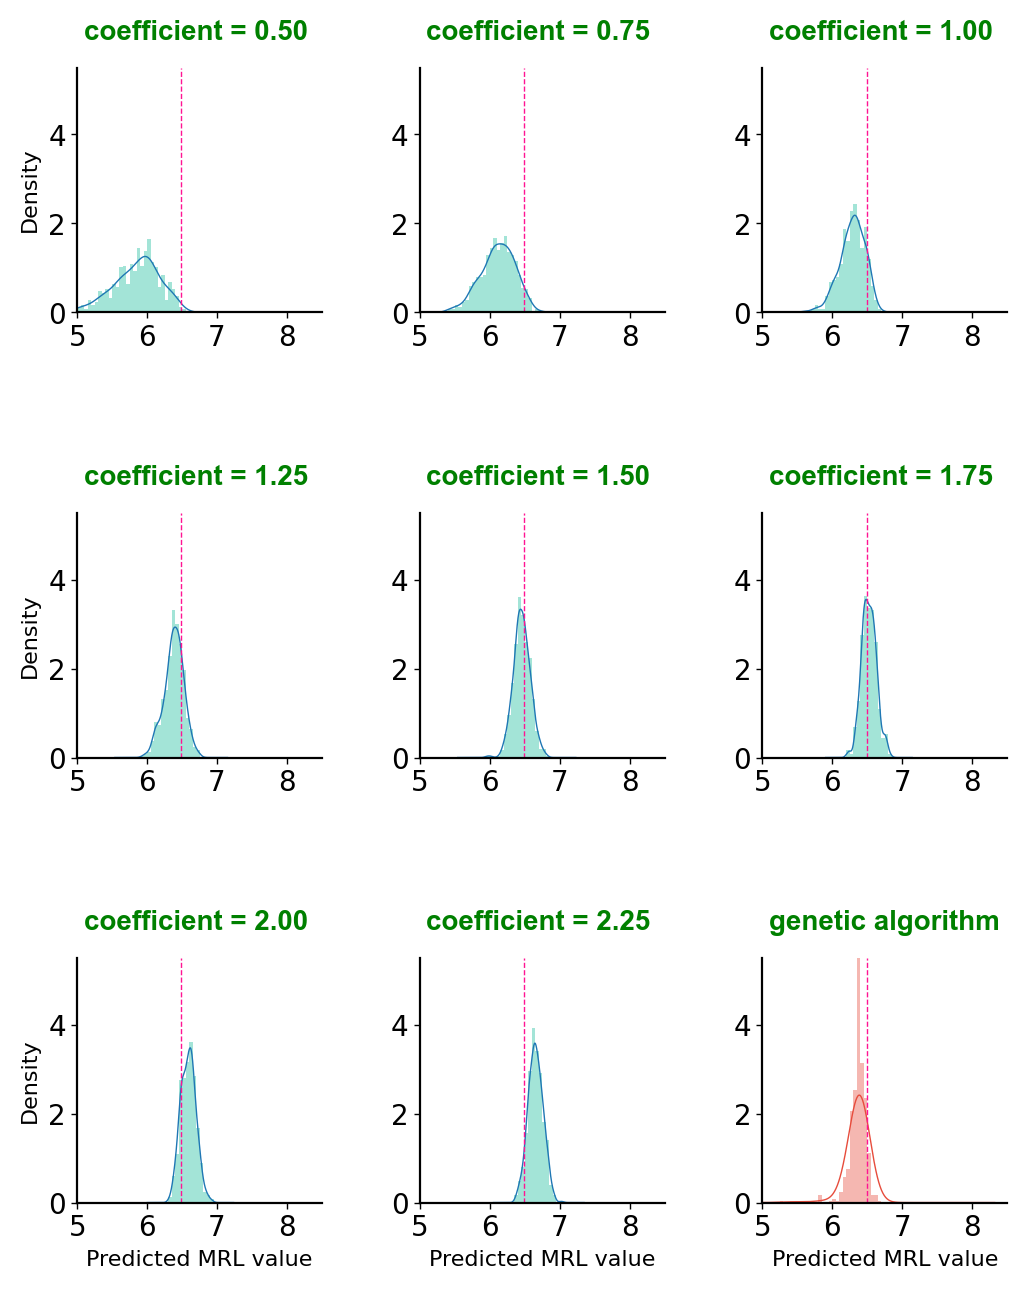

In [10]:
import warnings

warnings.filterwarnings('ignore')

fig = main()

In [11]:
fig.savefig('../figs/coef_disturbance_withoutannot_ae-ga.png', dpi=200)